In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
from scipy.stats import linregress
import seaborn as sns

# ========== CONFIGURATION ==========
TICKER = "ASO"  # Change this for different stocks
# ===================================


In [42]:
def get_stock_data(ticker):
    """Fetch and clean stock data from Yahoo Finance"""
    try:
        # Get raw stock data
        stock_data = yf.download(ticker, period="1y")
        
        # Fix multi-level columns
        stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]
        
        # Reset index and clean dates
        stock_data = stock_data.reset_index()
        stock_data['date'] = stock_data['Date'].dt.date
        stock_data.drop('Date', axis=1, inplace=True)
        
        return stock_data[['date', 'Close_' + ticker]]

    except Exception as e:
        print(f"❌ Error fetching stock data: {str(e)}")
        return None

In [43]:
def interpolate_zero_sentiment(daily_sentiment):
    """Replace zero sentiment values with average of nearest non-zero values"""
    df = daily_sentiment.copy()
    df = df.sort_values('date').reset_index(drop=True)
    
    zero_indices = df[df['score'] == 0].index.tolist()
    
    if not zero_indices:
        print("✅ No zero sentiment values found")
        return df
    
    print(f"🔧 Found {len(zero_indices)} zero sentiment values, interpolating...")
    
    for idx in zero_indices:
        # Search for non-zero values before and after
        before_val = None
        after_val = None
        
        # Search backwards for non-zero value
        for i in range(idx - 1, -1, -1):
            if df.loc[i, 'score'] != 0:
                before_val = df.loc[i, 'score']
                break
        
        # Search forwards for non-zero value
        for i in range(idx + 1, len(df)):
            if df.loc[i, 'score'] != 0:
                after_val = df.loc[i, 'score']
                break
        
        # Calculate replacement value
        if before_val is not None and after_val is not None:
            new_val = (before_val + after_val) / 2
            print(f"  📅 {df.loc[idx, 'date']}: 0.000 → {new_val:.3f} (avg of {before_val:.3f} & {after_val:.3f})")
        elif before_val is not None:
            new_val = before_val
            print(f"  📅 {df.loc[idx, 'date']}: 0.000 → {new_val:.3f} (using previous value)")
        elif after_val is not None:
            new_val = after_val
            print(f"  📅 {df.loc[idx, 'date']}: 0.000 → {new_val:.3f} (using next value)")
        else:
            new_val = 0.001  # Small positive value if no non-zero values found
            print(f"  📅 {df.loc[idx, 'date']}: 0.000 → {new_val:.3f} (default small value)")
        
        df.loc[idx, 'score'] = new_val
    
    return df

def merge_sentiment_price(ticker=TICKER):
    """Main function to handle full pipeline with zero interpolation"""
    try:
        # 1. Check for daily sentiment CSV
        try:
            sentiment_df = pd.read_csv(f"{ticker}_daily_sentiment.csv")
        except FileNotFoundError:
            print("⚠️ Daily sentiment CSV not found, generating now...")
            if not generate_daily_sentiment_csv(ticker):
                return None
            # Reload after generation
            sentiment_df = pd.read_csv(f"{ticker}_daily_sentiment.csv")

        # 2. Apply zero interpolation to sentiment data
        print(f"\n🔍 Checking for zero sentiment values in {ticker}...")
        sentiment_df = interpolate_zero_sentiment(sentiment_df)
        
        # 3. Process dates
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
        
        # 4. Get stock data
        stock_df = get_stock_data(ticker)
        if stock_df is None:
            return None
            
        # 5. Merge datasets
        merged_df = pd.merge(sentiment_df, stock_df, on='date', how='inner')
        
        if merged_df.empty:
            print("❌ No overlapping dates between sentiment and price data")
            return None
            
        # 6. Format and export
        merged_df['date'] = merged_df['date'].astype(str)
        merged_df.columns = ['date', 'sentiment', 'stock_price']
        output_path = f"{ticker}_sentiment_price_merged.csv"
        merged_df.to_csv(output_path, index=False)
        
        print(f"✅ Successfully exported merged data to {output_path}")
        
        # Verify no zeros remain
        zero_count = (merged_df['sentiment'] == 0).sum()
        if zero_count > 0:
            print(f"⚠️ Warning: {zero_count} zero sentiment values still remain")
        else:
            print("✅ All zero sentiment values successfully interpolated")
            
        return merged_df
        
    except Exception as e:
        print(f"❌ Unexpected error: {str(e)}")
        return None

def generate_daily_sentiment_csv(ticker):
    """Generate daily sentiment CSV from raw news data"""
    try:
        # Load raw news data
        input_path = f"{ticker}_news.csv"
        df = pd.read_csv(input_path)
        
        # Validate required columns
        if 'title' not in df.columns or 'publishedDate' not in df.columns:
            print(f"❌ CSV missing required columns: 'title' or 'publishedDate'")
            return False

        # Initialize sentiment analyzer
        analyzer = SentimentIntensityAnalyzer()
        
        # Calculate sentiment scores
        df['score'] = df['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
        
        # Clean and parse dates
        df['date'] = pd.to_datetime(df['publishedDate'], errors='coerce').dt.date
        df = df.dropna(subset=['date'])
        
        if df.empty:
            print("❌ No valid dates found after cleaning")
            return False

        # Aggregate daily sentiment
        daily_sentiment = df.groupby('date')['score'].mean().reset_index()
        
        # Export to CSV (interpolation will happen during merge)
        output_path = f"{ticker}_daily_sentiment.csv"
        daily_sentiment.to_csv(output_path, index=False)
        print(f"✅ Daily sentiment data saved to {output_path}")
        return True
        
    except FileNotFoundError:
        print(f"❌ Raw news file not found: {ticker}_news.csv")
        print("Please ensure you have the raw news CSV file first")
        return False
    except Exception as e:
        print(f"❌ Error generating sentiment CSV: {str(e)}")
        return False

# Run the full pipeline
if __name__ == "__main__":
    # 1. First ensure raw news data exists
    try:
        pd.read_csv(f"{TICKER}_news.csv")
    except FileNotFoundError:
        print(f"❌ Critical: Create {TICKER}_news.csv first with columns:")
        print("- title: News headline text")
        print("- publishedDate: Date in any format")
        exit()
    
    # 2. Run the full process
    result = merge_sentiment_price(TICKER)
    if result is not None:
        print(f"\nFinal data preview (showing no zeros):")
        print(result.head(10))


[*********************100%***********************]  1 of 1 completed

⚠️ Daily sentiment CSV not found, generating now...
✅ Daily sentiment data saved to ASO_daily_sentiment.csv

🔍 Checking for zero sentiment values in ASO...
🔧 Found 21 zero sentiment values, interpolating...
  📅 2024-06-24: 0.000 → 0.392 (avg of 0.402 & 0.382)
  📅 2024-07-19: 0.000 → 0.382 (avg of 0.382 & 0.382)
  📅 2024-07-21: 0.000 → 0.382 (avg of 0.382 & 0.382)
  📅 2024-08-22: 0.000 → 0.382 (avg of 0.382 & 0.382)
  📅 2024-08-26: 0.000 → 0.382 (avg of 0.382 & 0.382)
  📅 2024-08-27: 0.000 → 0.382 (avg of 0.382 & 0.382)
  📅 2024-09-05: 0.000 → 0.210 (avg of 0.318 & 0.101)
  📅 2024-11-26: 0.000 → -0.013 (avg of -0.077 & 0.051)
  📅 2024-12-06: 0.000 → 0.056 (avg of 0.197 & -0.085)
  📅 2024-12-14: 0.000 → 0.489 (avg of 0.557 & 0.421)
  📅 2025-01-21: 0.000 → 0.582 (avg of 0.421 & 0.743)
  📅 2025-02-24: 0.000 → 0.610 (avg of 0.743 & 0.477)
  📅 2025-03-04: 0.000 → 0.543 (avg of 0.610 & 0.477)
  📅 2025-03-06: 0.000 → 0.510 (avg of 0.543 & 0.477)
  📅 2025-03-07: 0.000 → 0.493 (avg of 0.510 & 0.

📊 Loaded 51 days of ASO data

📈 Statistical Analysis Results:
Pearson Correlation: 0.1025
R² Value: 0.0105
P-value: 0.4744


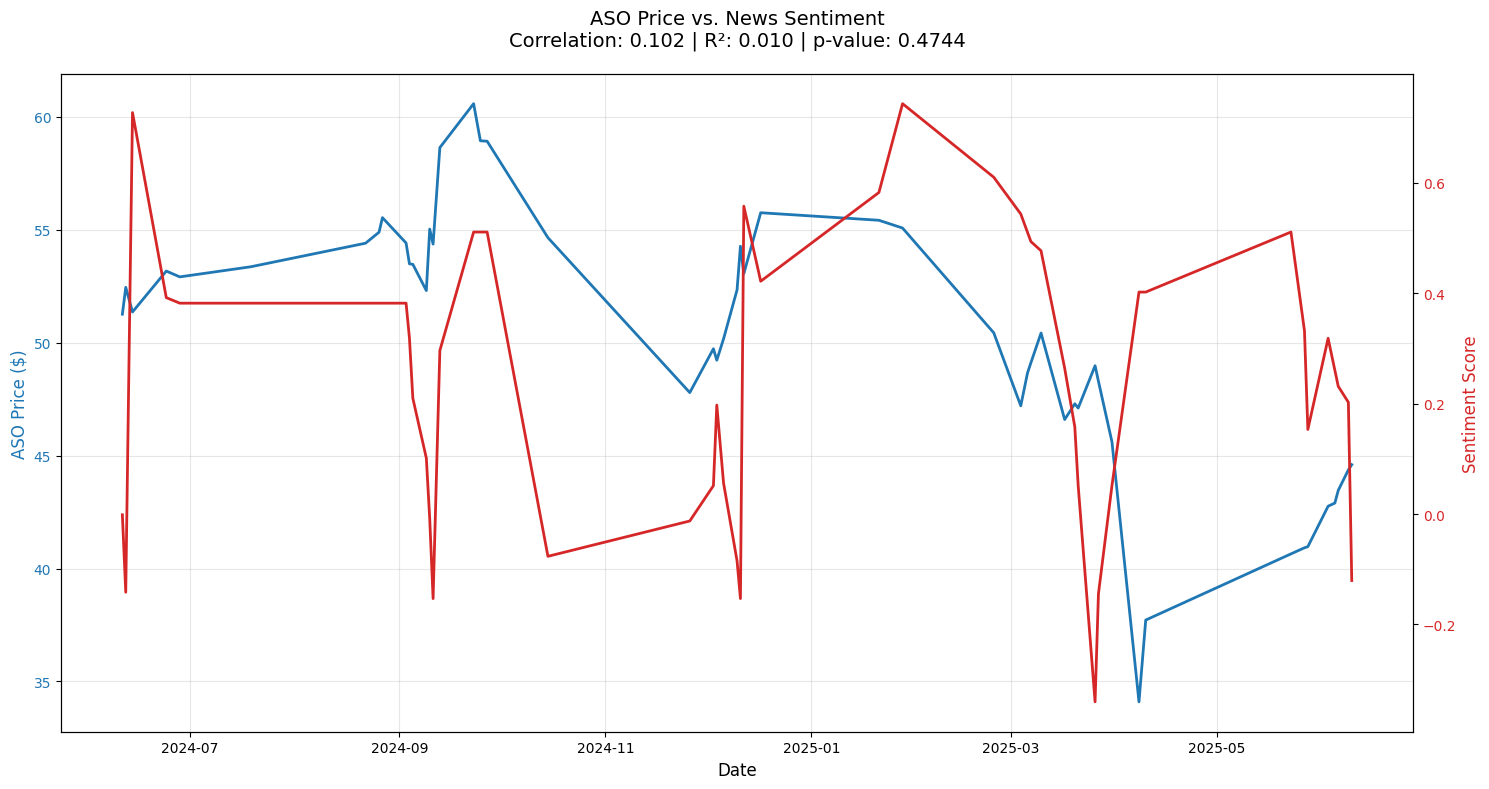


🔍 Interpretation:
Weak positive correlation between sentiment and price
❌ Not statistically significant (p >= 0.05)

📋 Sample of analyzed data:
        date  sentiment  stock_price
0 2024-06-11  -0.001356    51.260380
1 2024-06-12  -0.141575    52.450409
2 2024-06-14   0.726900    51.359550
3 2024-06-24   0.391850    53.172047
4 2024-06-28   0.381800    52.913685


In [44]:
def analyze_correlation_and_plot(ticker=TICKER):
    """Load merged data, calculate statistics, and create overlaid plot"""
    try:
        # 1. Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        df['date'] = pd.to_datetime(df['date'])
        
        print(f"📊 Loaded {len(df)} days of {ticker} data")
        
        # 2. Calculate correlation statistics
        correlation = df['sentiment'].corr(df['stock_price'])
        slope, intercept, r_value, p_value, _ = linregress(df['sentiment'], df['stock_price'])
        r_squared = r_value ** 2
        
        print("\n📈 Statistical Analysis Results:")
        print(f"Pearson Correlation: {correlation:.4f}")
        print(f"R² Value: {r_squared:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        # 3. Create dual-axis plot (like TSLA example)
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Plot stock price (blue line, left axis)
        ax1.plot(df['date'], df['stock_price'], color='#1f77b4', linewidth=2, label='Price')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{ticker} Price ($)', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for sentiment (red line, right axis)
        ax2 = ax1.twinx()
        ax2.plot(df['date'], df['sentiment'], color='#d62728', linewidth=2, label='Sentiment')
        ax2.set_ylabel('Sentiment Score', color='#d62728', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#d62728')
        
        # Title with correlation info
        plt.title(f'{ticker} Price vs. News Sentiment\nCorrelation: {correlation:.3f} | R²: {r_squared:.3f} | p-value: {p_value:.4f}', 
                 fontsize=14, pad=20)
        
        # Format x-axis
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 4. Print interpretation
        print("\n🔍 Interpretation:")
        if abs(correlation) >= 0.7:
            strength = "Strong"
        elif abs(correlation) >= 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
            
        direction = "positive" if correlation > 0 else "negative"
        print(f"{strength} {direction} correlation between sentiment and price")
        
        if p_value < 0.05:
            print("✅ Statistically significant (p < 0.05)")
        else:
            print("❌ Not statistically significant (p >= 0.05)")
            
        return {
            'correlation': correlation,
            'r_squared': r_squared,
            'p_value': p_value,
            'data': df
        }
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        print("Make sure you've run the merge step first!")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Run the analysis
if __name__ == "__main__":
    results = analyze_correlation_and_plot()
    
    if results:
        print(f"\n📋 Sample of analyzed data:")
        print(results['data'].head())


📈 Statistical Analysis Results (7-day MA):
Pearson Correlation: 0.1841
R² Value: 0.0339
P-value: 0.1958


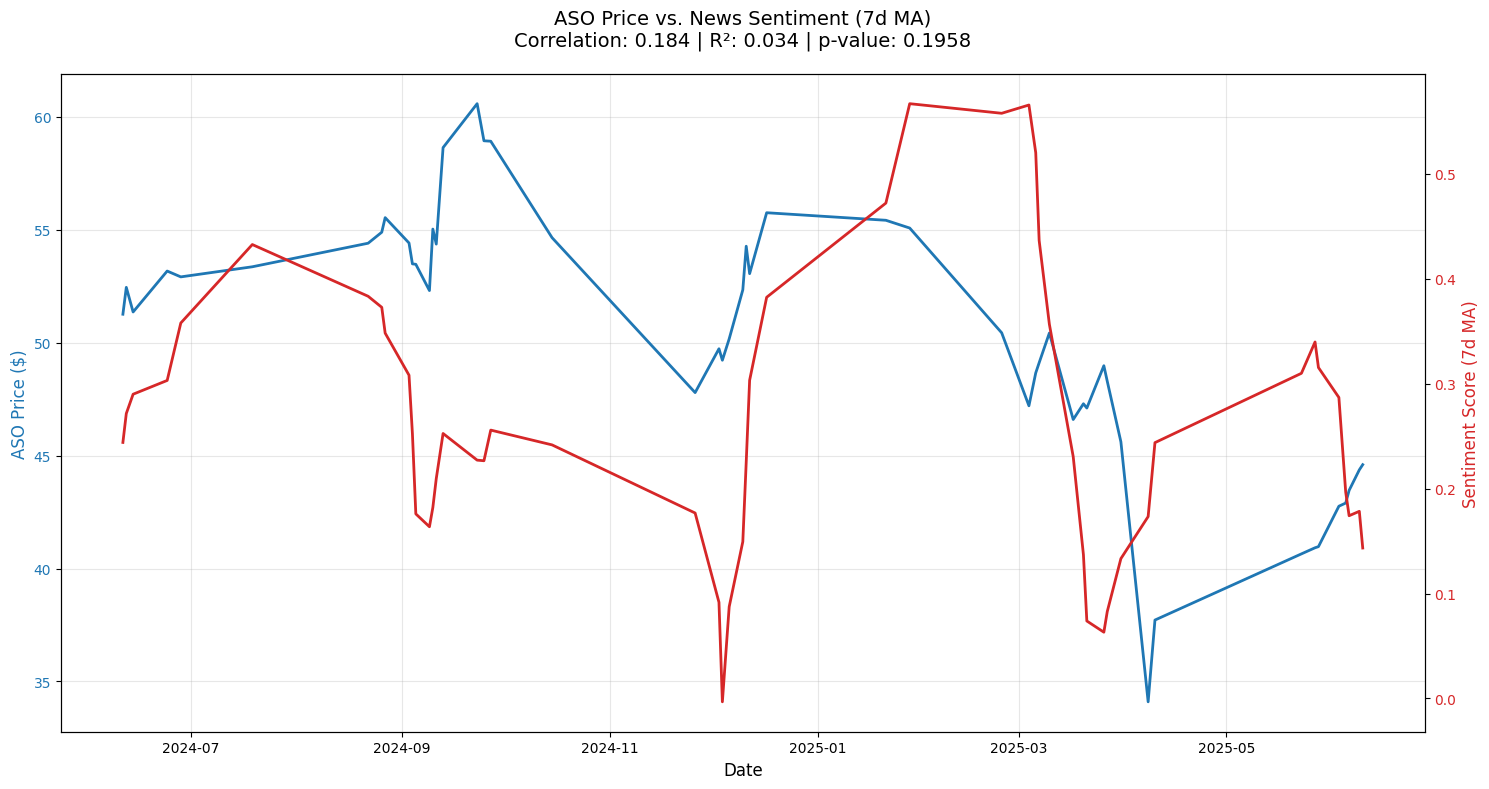

In [45]:
def analyze_correlation_and_plot(ticker=TICKER):
    df = pd.read_csv(f"{ticker}_sentiment_price_merged.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # 7-day moving average for sentiment
    df['sentiment_ma7'] = df['sentiment'].rolling(window=7, min_periods=1, center=True).mean()
    
    # Correlation and regression using the smoothed sentiment
    correlation = df['sentiment_ma7'].corr(df['stock_price'])
    slope, intercept, r_value, p_value, _ = linregress(df['sentiment_ma7'], df['stock_price'])
    r_squared = r_value ** 2

    print("\n📈 Statistical Analysis Results (7-day MA):")
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"R² Value: {r_squared:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(df['date'], df['stock_price'], color='#1f77b4', linewidth=2, label='Price')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel(f'{ticker} Price ($)', color='#1f77b4', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['sentiment_ma7'], color='#d62728', linewidth=2, label='Sentiment (7d MA)')
    ax2.set_ylabel('Sentiment Score (7d MA)', color='#d62728', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#d62728')
    
    plt.title(f'{ticker} Price vs. News Sentiment (7d MA)\nCorrelation: {correlation:.3f} | R²: {r_squared:.3f} | p-value: {p_value:.4f}', 
              fontsize=14, pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage
if __name__ == "__main__":
    analyze_correlation_and_plot()

📊 Loaded 51 days of ASO data for lag analysis

LAG CORRELATION INTERPRETATION GUIDE:
- Positive lag values mean SENTIMENT LEADING PRICE
  Example: Lag +5 = Today's sentiment vs. price 5 days later
- Negative lag values mean SENTIMENT FOLLOWING PRICE
  Example: Lag -5 = Today's sentiment vs. price 5 days earlier
- Lag 0 = Same-day correlation

🔍 Lag Correlation Analysis Results for ASO:
--------------------------------------------------
Lag -30 days: -0.243 (Sentiment follows price)
Lag -29 days: -0.125 (Sentiment follows price)
Lag -28 days: 0.014 (Sentiment follows price)
Lag -27 days: 0.071 (Sentiment follows price)
Lag -26 days: 0.034 (Sentiment follows price)
Lag -25 days: -0.057 (Sentiment follows price)
Lag -24 days: -0.152 (Sentiment follows price)
Lag -23 days: -0.236 (Sentiment follows price)
Lag -22 days: -0.224 (Sentiment follows price)
Lag -21 days: -0.168 (Sentiment follows price)
Lag -20 days: -0.033 (Sentiment follows price)
Lag -19 days: 0.158 (Sentiment follows price)


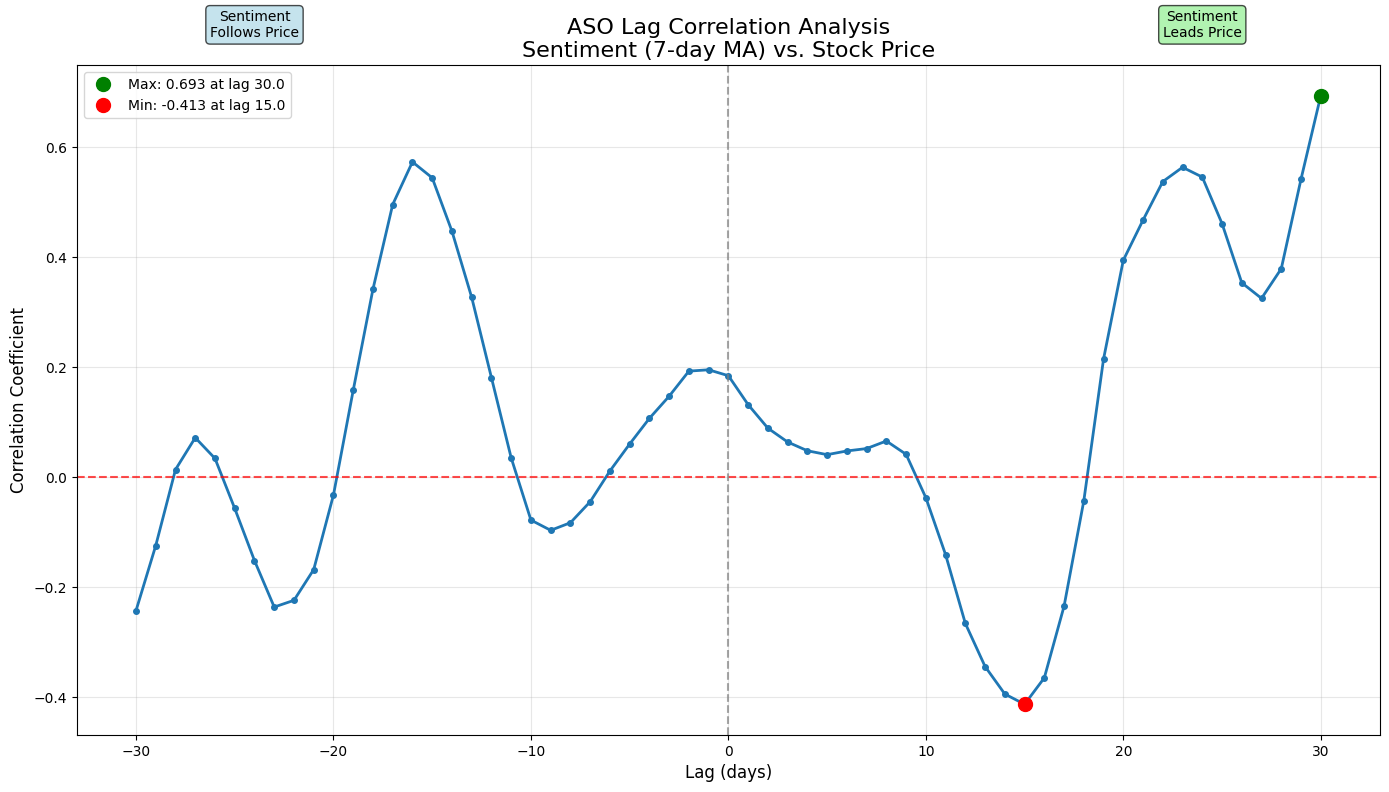


🔝 Top 5 Positive Correlations:
Lag 30.0 days: 0.693
Lag -16.0 days: 0.573
Lag 23.0 days: 0.563
Lag 24.0 days: 0.545
Lag -15.0 days: 0.544

🔻 Top 5 Negative Correlations:
Lag 15.0 days: -0.413
Lag 14.0 days: -0.395
Lag 16.0 days: -0.365
Lag 13.0 days: -0.345
Lag 12.0 days: -0.266


In [46]:
def perform_lag_analysis(ticker=TICKER, max_lag=30):
    """Perform lag correlation analysis between sentiment and stock price"""
    try:
        # Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        print(f"📊 Loaded {len(df)} days of {ticker} data for lag analysis")
        
        # Apply 7-day moving average to sentiment for smoother analysis
        df['sentiment_ma7'] = df['sentiment'].rolling(window=7, min_periods=1, center=True).mean()
        
        # Lag analysis explanation
        print("\n" + "="*60)
        print("LAG CORRELATION INTERPRETATION GUIDE:")
        print("- Positive lag values mean SENTIMENT LEADING PRICE")
        print("  Example: Lag +5 = Today's sentiment vs. price 5 days later")
        print("- Negative lag values mean SENTIMENT FOLLOWING PRICE") 
        print("  Example: Lag -5 = Today's sentiment vs. price 5 days earlier")
        print("- Lag 0 = Same-day correlation")
        print("="*60 + "\n")
        
        # Perform lag analysis
        lag_results = []
        print(f"🔍 Lag Correlation Analysis Results for {ticker}:")
        print("-" * 50)
        
        for lag in range(-max_lag, max_lag + 1):
            # Shift sentiment data by lag days
            shifted_sentiment = df['sentiment_ma7'].shift(lag)
            
            # Calculate correlation with stock price
            lag_corr = df['stock_price'].corr(shifted_sentiment)
            
            # Store results
            lag_results.append({'lag': lag, 'correlation': lag_corr})
            
            # Add interpretation suffix
            if lag > 0:
                interpretation = "(Sentiment leads price)"
            elif lag < 0:
                interpretation = "(Sentiment follows price)"
            else:
                interpretation = "(Same day)"
                
            print(f"Lag {lag:3} days: {lag_corr:.3f} {interpretation}")
        
        # Convert to DataFrame for analysis
        lag_df = pd.DataFrame(lag_results)
        
        # Find best correlations
        best_positive_lag = lag_df.loc[lag_df['correlation'].idxmax()]
        best_negative_corr = lag_df.loc[lag_df['correlation'].idxmin()]
        
        print(f"\n📈 SUMMARY:")
        print(f"Best positive correlation: {best_positive_lag['correlation']:.3f} at lag {best_positive_lag['lag']} days")
        print(f"Best negative correlation: {best_negative_corr['correlation']:.3f} at lag {best_negative_corr['lag']} days")
        
        # Create visualization
        plt.figure(figsize=(14, 8))
        plt.plot(lag_df['lag'], lag_df['correlation'], marker='o', linewidth=2, markersize=4)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
        
        # Highlight best correlations
        plt.plot(best_positive_lag['lag'], best_positive_lag['correlation'], 
                'go', markersize=10, label=f'Max: {best_positive_lag["correlation"]:.3f} at lag {best_positive_lag["lag"]}')
        plt.plot(best_negative_corr['lag'], best_negative_corr['correlation'], 
                'ro', markersize=10, label=f'Min: {best_negative_corr["correlation"]:.3f} at lag {best_negative_corr["lag"]}')
        
        plt.title(f'{ticker} Lag Correlation Analysis\nSentiment (7-day MA) vs. Stock Price', fontsize=16)
        plt.xlabel('Lag (days)', fontsize=12)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add interpretation zones
        plt.text(-max_lag*0.8, 0.8, 'Sentiment\nFollows Price', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
                horizontalalignment='center', fontsize=10)
        plt.text(max_lag*0.8, 0.8, 'Sentiment\nLeads Price', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                horizontalalignment='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        return lag_df
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        print("Make sure you've run the merge step first!")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Run lag analysis
if __name__ == "__main__":
    lag_results = perform_lag_analysis()
    
    if lag_results is not None:
        # Show top 5 positive and negative correlations
        print("\n🔝 Top 5 Positive Correlations:")
        top_positive = lag_results.nlargest(5, 'correlation')
        for _, row in top_positive.iterrows():
            print(f"Lag {row['lag']:3} days: {row['correlation']:.3f}")
            
        print("\n🔻 Top 5 Negative Correlations:")
        top_negative = lag_results.nsmallest(5, 'correlation')
        for _, row in top_negative.iterrows():
            print(f"Lag {row['lag']:3} days: {row['correlation']:.3f}")

📊 Loaded 51 days of ASO data

🔍 Finding optimal lag...
✅ Optimal lag found: 30 days (correlation: 0.693)

📈 Lagged Correlation Analysis Results (Lag: 30 days):
Pearson Correlation: 0.6932
R² Value: 0.4805
P-value: 0.0005


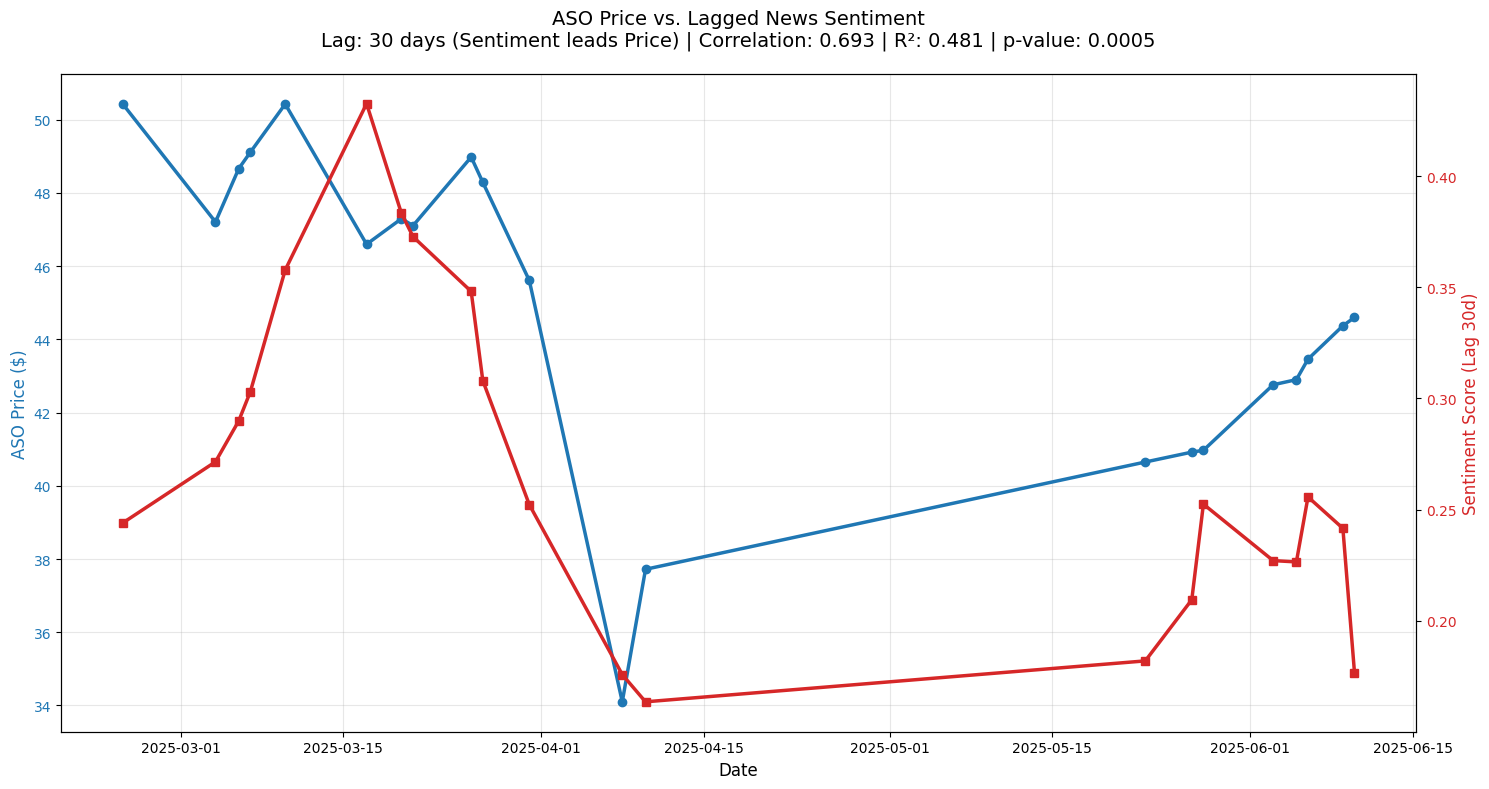


🔍 Interpretation:
📈 Sentiment LEADS price by 30 days
   → News sentiment predicts future price movements
✅ Highly statistically significant (p < 0.01)
💪 Moderate correlation detected

📋 Final Results Summary:
Optimal Lag: 30 days
Lagged Correlation: 0.6932
R² Value: 0.4805
P-value: 0.0005


In [47]:
def find_optimal_lag_and_plot(ticker=TICKER, max_lag=30):
    """Find optimal lag and create lagged correlation analysis"""
    try:
        # 1. Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        print(f"📊 Loaded {len(df)} days of {ticker} data")
        
        # 2. Apply 7-day moving average to sentiment
        df['sentiment_ma7'] = df['sentiment'].rolling(window=min(7, len(df)), min_periods=1, center=True).mean()
        
        # 3. Perform lag analysis to find optimal lag
        print("\n🔍 Finding optimal lag...")
        lag_results = []
        
        for lag in range(-max_lag, max_lag + 1):
            # Shift sentiment data by lag days
            shifted_sentiment = df['sentiment_ma7'].shift(lag)
            
            # Calculate correlation with stock price (only valid overlapping data)
            valid_mask = ~(shifted_sentiment.isna() | df['stock_price'].isna())
            if valid_mask.sum() > 2:  # Need at least 3 points for correlation
                lag_corr = df.loc[valid_mask, 'stock_price'].corr(shifted_sentiment[valid_mask])
                lag_results.append({'lag': lag, 'correlation': lag_corr})
        
        # Convert to DataFrame and find best positive correlation
        lag_df = pd.DataFrame(lag_results)
        best_positive = lag_df[lag_df['correlation'] > 0].sort_values('correlation', ascending=False)
        
        if best_positive.empty:
            print("❌ No positive correlations found, using lag 0")
            optimal_lag = 0
            optimal_corr = lag_df[lag_df['lag'] == 0]['correlation'].iloc[0]
        else:
            optimal_lag = int(best_positive.iloc[0]['lag'])
            optimal_corr = best_positive.iloc[0]['correlation']
        
        print(f"✅ Optimal lag found: {optimal_lag} days (correlation: {optimal_corr:.3f})")
        
        # 4. Apply optimal lag and calculate statistics
        df['sentiment_lagged'] = df['sentiment_ma7'].shift(optimal_lag)
        
        # Remove NaN values created by shifting
        analysis_df = df.dropna(subset=['sentiment_lagged', 'stock_price']).copy()
        
        if len(analysis_df) < 3:
            print("❌ Insufficient data after applying lag")
            return None
        
        # Calculate enhanced statistics
        correlation = analysis_df['sentiment_lagged'].corr(analysis_df['stock_price'])
        slope, intercept, r_value, p_value, _ = linregress(analysis_df['sentiment_lagged'], analysis_df['stock_price'])
        r_squared = r_value ** 2
        
        print(f"\n📈 Lagged Correlation Analysis Results (Lag: {optimal_lag} days):")
        print(f"Pearson Correlation: {correlation:.4f}")
        print(f"R² Value: {r_squared:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        # 5. Create visualization
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Plot stock price (blue line, left axis)
        ax1.plot(analysis_df['date'], analysis_df['stock_price'], 
                color='#1f77b4', linewidth=2.5, marker='o', markersize=6, label='Price')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{ticker} Price ($)', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for lagged sentiment (red line, right axis)
        ax2 = ax1.twinx()
        ax2.plot(analysis_df['date'], analysis_df['sentiment_lagged'], 
                color='#d62728', linewidth=2.5, marker='s', markersize=6, 
                label=f'Sentiment (Lag {optimal_lag}d)')
        ax2.set_ylabel(f'Sentiment Score (Lag {optimal_lag}d)', color='#d62728', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#d62728')
        
        # Enhanced title with all statistics
        lag_direction = "leads" if optimal_lag > 0 else "follows" if optimal_lag < 0 else "same-day"
        plt.title(f'{ticker} Price vs. Lagged News Sentiment\n'
                 f'Lag: {optimal_lag} days (Sentiment {lag_direction} Price) | '
                 f'Correlation: {correlation:.3f} | R²: {r_squared:.3f} | p-value: {p_value:.4f}', 
                 fontsize=14, pad=20)
        
        # Format dates and layout
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 6. Print interpretation
        print(f"\n🔍 Interpretation:")
        if optimal_lag > 0:
            print(f"📈 Sentiment LEADS price by {optimal_lag} days")
            print("   → News sentiment predicts future price movements")
        elif optimal_lag < 0:
            print(f"📉 Sentiment FOLLOWS price by {abs(optimal_lag)} days")
            print("   → News sentiment reacts to past price movements")
        else:
            print("📊 Same-day relationship")
            print("   → News sentiment and price move together")
        
        # Statistical significance
        if p_value < 0.01:
            print("✅ Highly statistically significant (p < 0.01)")
        elif p_value < 0.05:
            print("✅ Statistically significant (p < 0.05)")
        else:
            print("❌ Not statistically significant (p >= 0.05)")
        
        # Correlation strength
        if abs(correlation) >= 0.7:
            strength = "Strong"
        elif abs(correlation) >= 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
        print(f"💪 {strength} correlation detected")
        
        return {
            'optimal_lag': optimal_lag,
            'correlation': correlation,
            'r_squared': r_squared,
            'p_value': p_value,
            'data': analysis_df
        }
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Run the lagged analysis
if __name__ == "__main__":
    results = find_optimal_lag_and_plot()
    
    if results:
        print(f"\n📋 Final Results Summary:")
        print(f"Optimal Lag: {results['optimal_lag']} days")
        print(f"Lagged Correlation: {results['correlation']:.4f}")
        print(f"R² Value: {results['r_squared']:.4f}")
        print(f"P-value: {results['p_value']:.4f}")

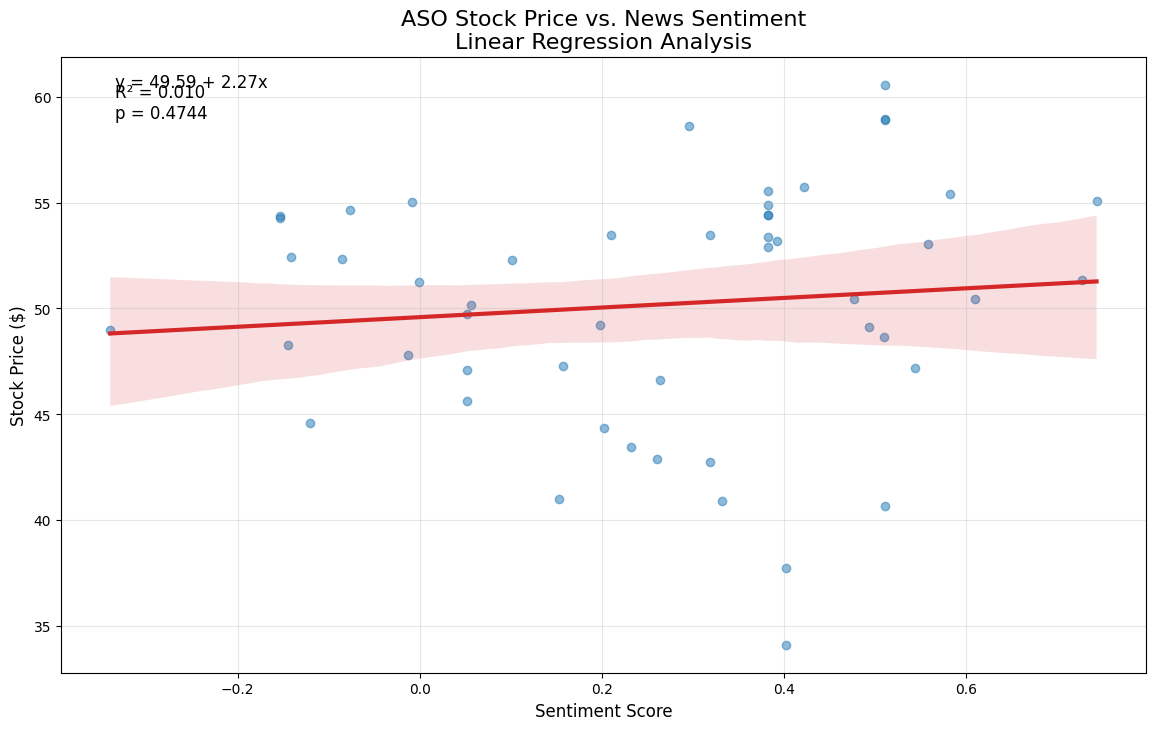

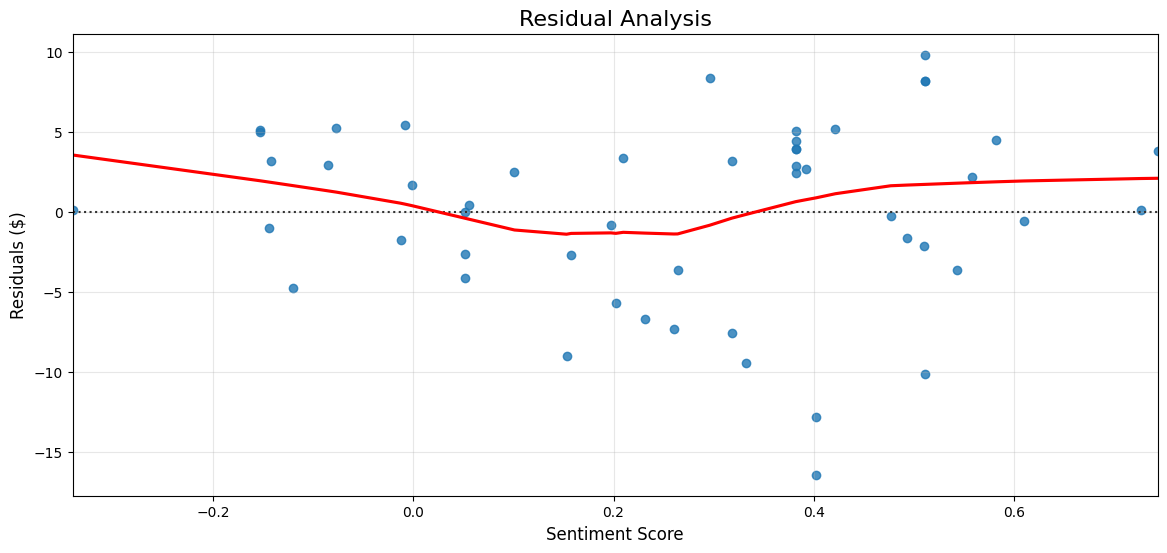


📈 Regression Results for ASO:
Equation: Stock Price = 49.59 + 2.27 * Sentiment
R-squared: 0.0105
P-value: 0.4744
Standard Error: 3.1532

🔍 Interpretation:
- Positive relationship (not statistically significant)
- Each 1-unit increase in sentiment corresponds to $2.27 price change
- Model explains 1.0% of price variation


In [48]:
def perform_regression_analysis(ticker=TICKER):
    """Perform linear regression and create visualization"""
    try:
        # Load merged data
        merged_path = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_path)
        
        # Convert to numeric types
        df['sentiment'] = pd.to_numeric(df['sentiment'])
        df['stock_price'] = pd.to_numeric(df['stock_price'])
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(df['sentiment'], df['stock_price'])
        r_squared = r_value ** 2
        
        # Create prediction line
        df['predicted_price'] = intercept + slope * df['sentiment']
        
        # Create figure
        plt.figure(figsize=(14, 8))
        
        # Scatter plot with regression line
        sns.regplot(x='sentiment', y='stock_price', data=df, 
                   scatter_kws={'alpha':0.5, 'color':'#1f77b4'},
                   line_kws={'color':'#d62728', 'linewidth':3})
        
        # Add equation and stats to plot
        equation = f'y = {intercept:.2f} + {slope:.2f}x'
        stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}'
        plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.05, 0.90, stats_text, transform=plt.gca().transAxes, fontsize=12)
        
        # Formatting
        plt.title(f'{ticker} Stock Price vs. News Sentiment\nLinear Regression Analysis', fontsize=16)
        plt.xlabel('Sentiment Score', fontsize=12)
        plt.ylabel('Stock Price ($)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Create residual plot (requires statsmodels)
        try:
            from statsmodels.nonparametric.smoothers_lowess import lowess
            plt.figure(figsize=(14, 6))
            residuals = df['stock_price'] - df['predicted_price']
            sns.residplot(x=df['sentiment'], y=residuals, 
                         lowess=True, line_kws={'color': 'red'})
            plt.title('Residual Analysis', fontsize=16)
            plt.xlabel('Sentiment Score', fontsize=12)
            plt.ylabel('Residuals ($)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.show()
        except ImportError:
            print("\n❌ Residual plot disabled: 'statsmodels' is required for LOWESS smoothing")
            print("Install it with: pip install statsmodels")
        
        # Print regression summary
        print(f"\n📈 Regression Results for {ticker}:")
        print(f"Equation: Stock Price = {intercept:.2f} + {slope:.2f} * Sentiment")
        print(f"R-squared: {r_squared:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Standard Error: {std_err:.4f}")
        
        # Interpretation
        print("\n🔍 Interpretation:")
        if p_value < 0.05:
            significance = "statistically significant"
        else:
            significance = "not statistically significant"
            
        direction = "positive" if slope > 0 else "negative"
        print(f"- {direction.capitalize()} relationship ({significance})")
        print(f"- Each 1-unit increase in sentiment corresponds to ${slope:.2f} price change")
        print(f"- Model explains {r_squared:.1%} of price variation")
        
        return {
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value
        }
        
    except FileNotFoundError:
        print(f"❌ Merged data file not found: {merged_path}")
        print(f"Please ensure {merged_path} exists in the current directory")
        return None
    except Exception as e:
        print(f"❌ Error in regression analysis: {str(e)}")
        return None

# Run the analysis
if __name__ == "__main__":
    results = perform_regression_analysis()

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# ========== CONFIGURATION ==========
TICKERS = ["AMZN", 'WMT', 'COST', 'HD', 'TGT', 'LOW', 'TJX', 'ORLY', 'BBY', 'WSM', 'ULTA', 'DKS', 'FIVE', 'GME', 'BBWI', 'CASY', 'AZO', 'MUSA', 'RH', 'ODP', 'SBH', 'BBW', 'WOOF', 'GPC', 'ASO']  # Add your tickers here
# ===================================

def analyze_single_stock(ticker):
    """Analyze a single stock's sentiment-price relationship"""
    try:
        # Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        
        # Convert date and ensure proper data types
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        print(f"✅ Loaded {len(df)} days of data for {ticker}")
        
        if len(df) < 10:
            print(f"⚠️ Insufficient data for {ticker}")
            return None
        
        # 1. Same-day correlation
        same_day_corr = df['sentiment'].corr(df['stock_price'])
        
        # 2. 7-day moving average correlation
        df['sentiment_ma7'] = df['sentiment'].rolling(window=7, min_periods=3).mean()
        valid_ma_data = df.dropna(subset=['sentiment_ma7'])
        
        if len(valid_ma_data) >= 5:
            ma7_corr = valid_ma_data['sentiment_ma7'].corr(valid_ma_data['stock_price'])
        else:
            ma7_corr = np.nan
        
        # 3. Lag analysis to find optimal POSITIVE correlation
        max_lag = min(15, len(df)//2)
        lag_results = []
        
        for lag in range(-max_lag, max_lag + 1):
            shifted_sentiment = df['sentiment'].shift(lag)
            valid_mask = ~shifted_sentiment.isna() & ~df['stock_price'].isna()
            
            if valid_mask.sum() >= 5:
                lag_corr = df.loc[valid_mask, 'stock_price'].corr(shifted_sentiment[valid_mask])
                if not np.isnan(lag_corr):
                    lag_results.append((lag, lag_corr))
        
        # Find optimal lag (highest POSITIVE correlation only)
        positive_lag_results = [(lag, corr) for lag, corr in lag_results if corr > 0]
        
        if positive_lag_results:
            optimal_lag_data = max(positive_lag_results, key=lambda x: x[1])
            optimal_lag = optimal_lag_data[0]
            optimal_lag_corr = optimal_lag_data[1]
        else:
            # If no positive correlations found, set to N/A
            optimal_lag = np.nan
            optimal_lag_corr = np.nan
            print(f"⚠️ No positive lag correlations found for {ticker}")
        
        # 4. Regression statistics
        if len(df) >= 10:
            slope, intercept, r_value, p_value, _ = linregress(df['sentiment'], df['stock_price'])
            r_squared = r_value ** 2
        else:
            r_squared = np.nan
            p_value = np.nan
        
        # Return results
        return {
            'Ticker': ticker,
            'Same Day Correlation': same_day_corr,
            '7D MA Correlation': ma7_corr,
            'Optimal Lag Days': optimal_lag,
            'Optimal Lag Correlation': optimal_lag_corr,
            'R-squared': r_squared,
            'P-value': p_value,
            'Data Points': len(df)
        }
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        return None
    except Exception as e:
        print(f"❌ Error analyzing {ticker}: {str(e)}")
        return None

def generate_summary_table(tickers):
    """Generate comprehensive summary table for all stocks"""
    print("🔍 Analyzing sentiment-price relationships for multiple stocks...")
    print("="*60)
    
    all_results = []
    
    for ticker in tickers:
        print(f"\nAnalyzing {ticker}...")
        result = analyze_single_stock(ticker)
        
        if result:
            # Format the results with proper rounding
            formatted_result = {
                'Ticker': ticker,
                'Same Day Correlation': round(result['Same Day Correlation'], 3) if not np.isnan(result['Same Day Correlation']) else 'N/A',
                '7D MA Correlation': round(result['7D MA Correlation'], 3) if not np.isnan(result['7D MA Correlation']) else 'N/A',
                'Optimal Lag Days': int(result['Optimal Lag Days']) if not np.isnan(result['Optimal Lag Days']) else 'N/A',
                'Optimal Lag Correlation': round(result['Optimal Lag Correlation'], 3) if not np.isnan(result['Optimal Lag Correlation']) else 'N/A',
                'R-squared': round(result['R-squared'], 3) if not np.isnan(result['R-squared']) else 'N/A',
                'P-value': round(result['P-value'], 4) if not np.isnan(result['P-value']) else 'N/A',
                'Data Points': result['Data Points']
            }
            all_results.append(formatted_result)
            print(f"✅ Completed analysis for {ticker}")
        else:
            print(f"❌ Skipped {ticker} due to missing data or errors")
    
    # Create DataFrame
    if all_results:
        summary_df = pd.DataFrame(all_results)
        
        # Save to CSV
        summary_csv = "stock_sentiment_summary.csv"
        summary_df.to_csv(summary_csv, index=False)
        
        print(f"\n{'='*60}")
        print(f"📊 Analysis Complete! Summary saved to: {summary_csv}")
        print(f"{'='*60}")
        
        # Display the results table
        print("\n📈 FINAL SUMMARY TABLE:")
        print(summary_df.to_string(index=False))
        
        # Additional insights
        print(f"\n📋 KEY INSIGHTS:")
        print(f"• Total stocks analyzed: {len(all_results)}")
        
        # Find best positive correlations
        valid_results = [r for r in all_results if r['Optimal Lag Correlation'] != 'N/A']
        if valid_results:
            best_lag_stock = max(valid_results, key=lambda x: x['Optimal Lag Correlation'])
            print(f"• Best positive lag correlation: {best_lag_stock['Ticker']} ({best_lag_stock['Optimal Lag Correlation']} at {best_lag_stock['Optimal Lag Days']} days)")
        
        return summary_df
    else:
        print("❌ No valid data found for any stocks")
        return None

# Run the analysis
if __name__ == "__main__":
    summary_table = generate_summary_table(TICKERS)


🔍 Analyzing sentiment-price relationships for multiple stocks...

Analyzing AMZN...
✅ Loaded 49 days of data for AMZN
✅ Completed analysis for AMZN

Analyzing WMT...
✅ Loaded 138 days of data for WMT
✅ Completed analysis for WMT

Analyzing COST...
✅ Loaded 228 days of data for COST
⚠️ No positive lag correlations found for COST
✅ Completed analysis for COST

Analyzing HD...
✅ Loaded 191 days of data for HD
✅ Completed analysis for HD

Analyzing TGT...
✅ Loaded 167 days of data for TGT
✅ Completed analysis for TGT

Analyzing LOW...
✅ Loaded 151 days of data for LOW
✅ Completed analysis for LOW

Analyzing TJX...
✅ Loaded 147 days of data for TJX
⚠️ No positive lag correlations found for TJX
✅ Completed analysis for TJX

Analyzing ORLY...
✅ Loaded 62 days of data for ORLY
⚠️ No positive lag correlations found for ORLY
✅ Completed analysis for ORLY

Analyzing BBY...
✅ Loaded 92 days of data for BBY
✅ Completed analysis for BBY

Analyzing WSM...
✅ Loaded 119 days of data for WSM
✅ Completed